In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [4]:
df=pd.read_csv("data/NSE-Tata.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [5]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

In [8]:
df.index

DatetimeIndex(['2018-10-08', '2018-10-05', '2018-10-04', '2018-10-03',
               '2018-10-01', '2018-09-28', '2018-09-27', '2018-09-26',
               '2018-09-25', '2018-09-24',
               ...
               '2013-10-22', '2013-10-21', '2013-10-18', '2013-10-17',
               '2013-10-15', '2013-10-14', '2013-10-11', '2013-10-10',
               '2013-10-09', '2013-10-08'],
              dtype='datetime64[ns]', name='Date', length=1235, freq=None)

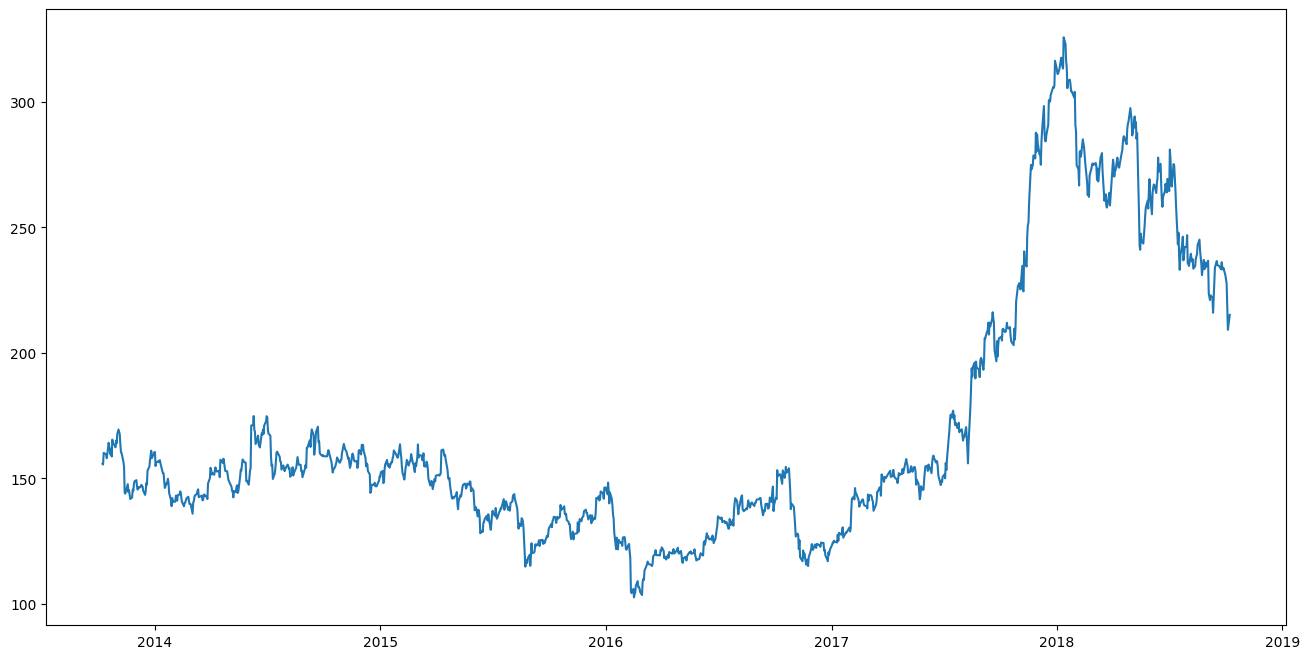

In [10]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [11]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [18]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [25]:
new_dataset = data[['Date', 'Close']].copy()
new_dataset.tail()

,Date,Close
Date,,
2018-10-01,2018-10-01,230.90
2018-10-03,2018-10-03,227.60
2018-10-04,2018-10-04,218.20
2018-10-05,2018-10-05,209.20
2018-10-08,2018-10-08,215.15


In [26]:
new_dataset.tail()


,Date,Close
Date,,
2018-10-01,2018-10-01,230.90
2018-10-03,2018-10-03,227.60
2018-10-04,2018-10-04,218.20
2018-10-05,2018-10-05,209.20
2018-10-08,2018-10-08,215.15


In [27]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [28]:
new_dataset.head()

,Close
Date,
2013-10-08,155.80
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


In [29]:
final_dataset=new_dataset.values

In [42]:
final_dataset
# len(final_dataset)

array([[155.8 ],
       [155.55],
       [160.15],
       ...,
       [218.2 ],
       [209.2 ],
       [215.15]])

In [32]:
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

In [47]:
len(train_data)


987

In [48]:
len(valid_data)

248

In [50]:
len(train_data) + len(valid_data) == len(final_dataset)

True

In [43]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [44]:
scaled_data
# len(scaled_data)

array([[0.23823398],
       [0.2371134 ],
       [0.25773196],
       ...,
       [0.51792918],
       [0.47758853],
       [0.50425818]])

In [51]:
x_train_data,y_train_data=[],[]

In [52]:
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [53]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [54]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))


In [18]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 31s - loss: 0.0011 - 31s/epoch - 33ms/step


In [19]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [20]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [21]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

8/8 [==============================] - 2s 49ms/step


In [22]:
lstm_model.save("data/saved_lstm_model.h5")

c:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\parme\AppData\Local\Temp\ipykernel_6048\4128311284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


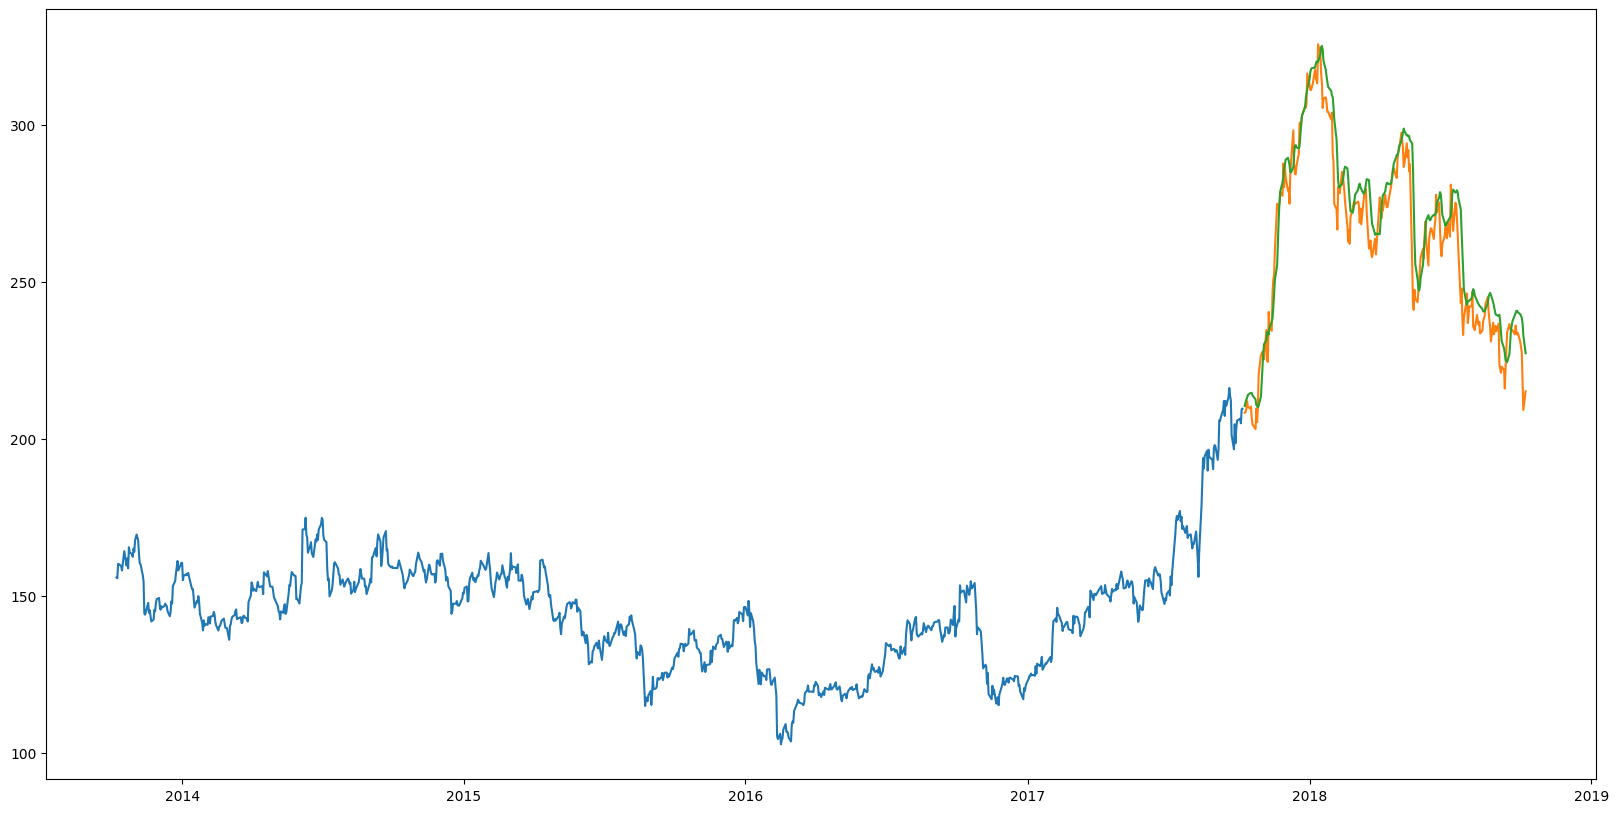

In [23]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])